In [ ]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=sk-替换为自己的Key

In [2]:
!pip install lightrag-hku aioboto3 ollama nano_vectordb langchain langchain-community langchain-openai langchain_chroma pypdf sentence_transformers shutil openpyxl FlagEmbedding

In [3]:
import os, lightrag, aioboto3, nano_vectordb

for module in (lightrag, aioboto3, nano_vectordb):
    print(f"{module.__name__:<10}\t{module.__version__}")

lightrag  	1.1.2
aioboto3  	13.3.0
nano_vectordb	0.0.4.1


在Notebook中需要这个，否则会报错

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
expr_version = 'kg_v01_lightrag'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

os.makedirs(expr_dir, exist_ok=True)

# 准备文档

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

In [7]:
import re

pattern = r"^全球经济金融展望报告\n中国银行研究院 \d+ 2024年"
processed_texts = '\n'.join(re.sub(pattern, '', doc.page_content) for doc in documents)

# 准备LightRAG

## 创建LightRAG实例

In [8]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

async def hf_ollama_embedding(texts: list[str], hf_embed_model) -> np.ndarray:
    embed_text = []
    for text in texts:
        data = hf_embed_model.embed_query(text)
        embed_text.append(data)

    return np.array(embed_text)

device: cuda


In [9]:
from lightrag import LightRAG
from lightrag.llm import ollama_model_complete
from lightrag.utils import EmbeddingFunc

model_path = 'BAAI/bge-large-zh-v1.5'
embeddings = get_embeddings(model_path)
rag = LightRAG(
    working_dir=expr_dir,
    llm_model_func=ollama_model_complete,
    llm_model_name='qwen2:7b-instruct-32k',
    chunk_token_size=500,
    chunk_overlap_token_size=50,
    embedding_func=EmbeddingFunc(
        embedding_dim=1024,
        max_token_size=500,
        func=lambda texts: hf_ollama_embedding(
            texts,
            hf_embed_model=embeddings
        )
        # func=lambda texts: ollama_embedding(
        #     texts,
        #     embed_model="znbang/bge:large-zh-v1.5-q8_0"
        # )
        # func=lambda text: hf_embedding(
        #     text,
        #     tokenizer=AutoTokenizer.from_pretrained(model_path),
        #     embed_model=AutoModel.from_pretrained(model_path, device_map=device)
        # )
    )
)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:datasets:PyTorch version 2.3.1 available.
INFO:datasets:JAX version 0.4.26 available.
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: /DataScience/HuggingFace/Models/BAAI/bge-large-zh-v1.5
INFO:lightrag:Logger initialized for working directory: ../experiments/kg_v01_lightrag
INFO:lightrag:Load KV json_doc_status_storage with 0 data
INFO:lightrag:Load KV llm_response_cache with 308 data
INFO:lightrag:Load KV full_docs with 1 data
INFO:lightrag:Load KV text_chunks with 52 data
INFO:lightrag:Loaded graph from ../experiments/kg_v01_lightrag/graph_chunk_entity_relation.graphml with 499 nodes, 72 edges
INFO:nano-vectordb:Load (431, 1024) data
INFO:nano-vectordb:Init {'embedding_dim': 1024, 'metric': 'cosine', 'storage_file': '../experiments/kg_v01_lightrag/vdb_entities.json'} 431 data
INFO:nano-vectordb:Load (72, 1024) data
INFO:nano-vectordb:Init {'embedding_dim': 1024, 'metric': 'cosine', 'storage_

## 建立索引

In [10]:
rag.insert(processed_texts)

INFO:lightrag:Processing 1 new unique documents
Processing batch 1:   0%|                                                                                                                              | 0/1 [00:00<?, ?it/s]INFO:lightrag:Inserting 52 vectors to chunks

Generating embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/batch]

Level 2 - Extracting entities and relationships:   0%|                                                                                             | 0/52 [00:00<?, ?chunk/s]
Level 2 - Extracting entities and relationships:   2%|█▌                                                                                | 1/52 [03:32<3:00:17, 212.11s/chunk]
Level 2 - Extracting entities and relationships:   4%|███▏                                                                               | 2/52 [03:44<1:18:41, 94.43s/chunk]
Level 2 - Extracting entities and re

## 尝试一下

In [12]:
from lightrag import QueryParam

### 检索

#### naive

In [13]:
print(rag.query(
    '报告的发布日期是什么时候？',
    QueryParam(
        mode='naive',
        only_need_context=True,
        top_k=2
    )
))

INFO:lightrag:Truncate 2 to 2 chunks


，任何机构和个人不得以任何形式翻版、复
制和发布。如引用发布，需注明出处为中国银行研究院，且不得对本报告进行有悖原意的引用、删节和修
改。中国银行研究院保留对任何侵权行为和有悖报告原意的引用行为进行追究的权利。
研究院
中国北京市复兴门内大街1号
邮编：100818
电话：+86-10-66592780
传真：+86-10-66594040
--New Chunk--
研究院
全球经济金融展望报告
要点2024年年报（总第57期） 报告日期：2023年12月12日
●2023年全球经济增长动力持续回落，各国复苏分化，
发达经济体增速明显放缓，新兴经济体整体表现稳定。
全球贸易增长乏力，各国生产景气度逐渐回落，内需
对经济的拉动作用减弱。欧美央行货币政策紧缩态势
放缓，美元指数高位震荡后走弱，全球股市表现总体
好于预期，但区域分化明显。高利率环境抑制债券融
资需求，债券违约风险持续上升。
●展望2024年，预计全球经济复苏将依旧疲软，主要
经济体增长态势和货币政策走势将进一步分化。欧美
央行大概率结束本轮紧缩货币周期，美元指数将逐步
走弱，流向新兴经济体的跨境资本将增加。国际原油
市场短缺格局或延续，新能源发展成为重点。
●海湾六国经济发展与投资前景、高利率和高债务对
美国房地产市场脆弱性的影响等热点问题值得关注。中国银行研究院
全球经济金融研究课题组
组长：陈卫东
副组长：钟红
廖淑萍
成员：边卫红
熊启跃
王有鑫
曹鸿宇
李颖婷
王宁远
初晓
章凯莉
黄小军（纽约）
陆晓明（纽约）
黄承煜（纽约）
宋达志（伦敦）
李振龙（伦敦）
张传捷（伦敦）
刘冰彦（法兰克福）
温颍坤（法兰克福）
张明捷（法兰克福）
王哲（东京）
李彧（香港）
黎永康（香港）
联系人：王有鑫
电话：010-66594127
邮件：wangyouxin_hq@bank-of-china.com主要经济体GDP增速变化趋势（%）
资料来源：IMF，中国银行研究院


全球经济复苏疲软，货币政策取向


#### global

In [14]:
print(rag.query(
    '报告的发布日期是什么时候？',
    QueryParam(
        mode='global',
        only_need_context=True,
        top_k=2
    )
))

INFO:lightrag:kw_prompt result:
INFO:lightrag:Using global mode for query processing
INFO:lightrag:Global query uses 4 entites, 2 relations, 2 text units


{
  "high_level_keywords": ["Report", "Publication date"],
  "low_level_keywords": []
}

-----Entities-----
```csv
id,entity,type,description,rank
0,"""GDP""","""EVENT""","""Gross Domestic Product (GDP) is used as a measure to gauge global economic performance, with forecasts for growth rates.""",4
1,"""UNITED KINGDOM""","""GEO""","""The United Kingdom demonstrates a decline in GDP growth compared to previous years due to various economic factors.""",1
2,"""2024年""","""EVENT""","""2024年的经济预测包括欧元、英镑和日元汇率的波动，以及新兴经济体货币的变化.""<SEP>""在2024年这一时间点，美联储可能会调整其货币政策.""|"">具体时间,经济预测""|7",1
3,"""中国银行全球经济金融展望报告""","""ORGANIZATION""","""中国银行全球经济金融展望报告是由中国银行研究院发布的关于全球经济和金融市场预测的年度报告.""",1

```
-----Relationships-----
```csv
id,source,target,description,keywords,weight,rank,created_at
0,"""GDP""","""UNITED KINGDOM""","""The United Kingdom's GDP is observed for its decline from 2022 levels due to a variety of economic pressures.""","""economic indicator tracking, historical comparison""",7.0,5,
1,"""2024年"

#### hybrid

In [15]:
print(rag.query(
    '报告的发布日期是什么时候？',
    QueryParam(
        mode='hybrid',
        only_need_context=True,
        top_k=2
    )
))

INFO:lightrag:kw_prompt result:
INFO:lightrag:Using global mode for query processing
INFO:lightrag:Global query uses 4 entites, 2 relations, 2 text units


{
  "high_level_keywords": ["Report", "Publication date"],
  "low_level_keywords": []
}

-----Entities-----
```csv
id,entity,type,description,rank
0,"""GDP""","""EVENT""","""Gross Domestic Product (GDP) is used as a measure to gauge global economic performance, with forecasts for growth rates.""",4
1,"""UNITED KINGDOM""","""GEO""","""The United Kingdom demonstrates a decline in GDP growth compared to previous years due to various economic factors.""",1
2,"""2024年""","""EVENT""","""2024年的经济预测包括欧元、英镑和日元汇率的波动，以及新兴经济体货币的变化.""<SEP>""在2024年这一时间点，美联储可能会调整其货币政策.""|"">具体时间,经济预测""|7",1
3,"""中国银行全球经济金融展望报告""","""ORGANIZATION""","""中国银行全球经济金融展望报告是由中国银行研究院发布的关于全球经济和金融市场预测的年度报告.""",1

```
-----Relationships-----
```csv
id,source,target,description,keywords,weight,rank,created_at
0,"""GDP""","""UNITED KINGDOM""","""The United Kingdom's GDP is observed for its decline from 2022 levels due to a variety of economic pressures.""","""economic indicator tracking, historical comparison""",7.0,5,
1,"""2024年"

#### local

In [16]:
print(rag.query(
    '报告的发布日期是什么时候？',
    QueryParam(
        mode='local',
        only_need_context=True,
        top_k=2
    )
))

INFO:lightrag:kw_prompt result:
INFO:lightrag:Using global mode for query processing
INFO:lightrag:Global query uses 4 entites, 2 relations, 2 text units


{
  "high_level_keywords": ["Report", "Release date"],
  "low_level_keywords": []
}

-----Entities-----
```csv
id,entity,type,description,rank
0,"""2023年""","""GEO""","""2023年被描述为全球经济趋势的一年，包括GDP增速、区域复苏、供应链恢复等指标的分析。""<SEP>""时间点描述，具体到2023年，包括贷款需求下降、新发放量下降以及资产价格变化的情况。""",3
1,"""新发放量下降""","""UNKNOWN""","""特定时间点的新发放量变化，表明市场活动和需求的变化。""",1
2,"""2024年""","""EVENT""","""2024年的经济预测包括欧元、英镑和日元汇率的波动，以及新兴经济体货币的变化.""<SEP>""在2024年这一时间点，美联储可能会调整其货币政策.""|"">具体时间,经济预测""|7",1
3,"""中国银行全球经济金融展望报告""","""ORGANIZATION""","""中国银行全球经济金融展望报告是由中国银行研究院发布的关于全球经济和金融市场预测的年度报告.""",1

```
-----Relationships-----
```csv
id,source,target,description,keywords,weight,rank,created_at
0,"""2023年""","""新发放量下降""","""特定时间点的新发放量变化，表明市场活动和需求的变化。""","""时间与事件关系""",6.0,4,
1,"""2024年""","""中国银行全球经济金融展望报告""","""The China Bank's global economic and financial outlook report for 2024 provides insights into future economic scenarios.""","""report, forecasting""",9.0,2,2025-01-16 22:28:22

```
-----Sources-----
```csv
id,content
0,"到期，35%以

### 问答

In [18]:
print(rag.query(
    '报告的发布日期是什么时候？',
    QueryParam(
        mode='global',
        top_k=2
    )
))

这份报告是在2023年发布的。文中提到的具体时间点包括：

1. 中国银行研究院在2023年的报告中分析了美国经济的情况。
2. 在报告中讨论了2023年的全球GDP增速预期，这一数据来自国际货币基金组织（IMF）和中国银行研究院的预测。
3. 说明沙特阿拉伯、埃及、阿联酋等国在2022年加入了金砖国家组织，并在2023年继续合作，这表明报告至少覆盖了2022年至2023年的信息。

通过这些细节可以推断出该报告的发布日期应该是在2023年。具体到哪一天则未直接明确给出，但基于其内含的分析和数据，可以合理推测报告可能是于当年某个时间点进行发布或最终定稿的。


In [19]:
print(rag.query(
    '报告的发布日期是什么时候？',
    QueryParam(
        mode='local',
        top_k=2
    )
))

INFO:lightrag:kw_prompt result:
INFO:lightrag:Using global mode for query processing
INFO:lightrag:Global query uses 4 entites, 2 relations, 2 text units


{
  "high_level_keywords": ["Report", "Publication date"],
  "low_level_keywords": []
}
中国银行全球经济金融展望报告（2024年）的发布时间记录在数据表中，具体时间为2025年1月16日。这一报告由中国的银行业研究院负责发布，内容包含了关于全球经济发展和金融市场预测的详细信息。

从提供的数据可以了解到，在过去的一年内，全球经济增长动力持续减弱，经济增速出现了连续两年下降的趋势。报告提到了一些关键点：

- 发达经济体的增长速度明显放缓。
- 新兴经济体的增长与2022年大致持平，但也有一定幅度的减速。
- 全球供应链持续恢复，但生产活动的景气度正在逐渐回落。

在需求端的表现上，报告指出内需对经济增长的拉动作用逐渐减弱，并且各国国内投资和跨境投资均面临压力。全球货物贸易量指数和价格指数下行，主要经济体出口增速下降。欧美央行的货币政策继续收紧，尽管步伐已经有所放缓；金融体系中短期资金运行出现了结构性变化，“去存款化”现象明显。

对于货币市场而言，报告指出美元指数在高位震荡后开始走弱，全球股市总体表现较好但存在区域差异。高利率环境抑制了债券融资需求，并导致债券违约风险持续上升。美国政府债务的可持续性问题也引起了市场的关注。

展望2024年，全球经济预计将继续保持疲软的状态，主要经济体的增长态势和货币政策将呈现进一步分化的特点。报告预测欧美央行可能会结束本轮加息周期，日本央行可能退出负利率政策，跨境资本回流至美国的趋势会放缓，更多资金将流向新兴经济体。美元指数预计将逐步走弱，这有望促进新兴经济体货币汇率的回升。

国际原油市场可能继续保持短缺格局，而新能源发展则被列为全球关注的重点之一。报告通过具体分析海湾六国经济发展与投资前景以及高利率和高债务对美国房地产市场的脆弱性影响这两个专题，为读者提供了更深入的理解。


In [20]:
print(rag.query(
    '报告的发布日期是什么时候？',
    QueryParam(
        mode='hybrid',
        top_k=2
    )
))

INFO:lightrag:kw_prompt result:
INFO:lightrag:Using global mode for query processing
INFO:lightrag:Global query uses 4 entites, 2 relations, 2 text units


{
  "high_level_keywords": ["Report", "Release date"],
  "low_level_keywords": []
}
中国银行全球经济金融展望报告是在2024年的某个时间点发布的。该报告提供了对未来全球经济发展和金融市场预测的见解，包括对欧元、英镑和日元汇率波动以及新兴经济体货币变化的分析，并指出在2024年期间美联储可能会调整其货币政策。

根据提供的信息，无法精确确定这份报告的具体发布日期。通常，经济展望报告会在新一年开始时发布，用来预测未来一年全球经济和金融市场的走势，因此可以合理推测中国银行全球金融展望报告是在2024年初发布的。


In [21]:
print(rag.query(
    '报告的发布日期是什么时候？',
    QueryParam(
        mode='naive',
        top_k=2
    )
))

INFO:lightrag:Truncate 2 to 2 chunks


报告《全球经济金融展望报告》的发布日期为2023年12月12日。这是由中国银行研究院在这一日期发布的年度经济报告，旨在提供对全球经济增长、金融市场变动以及宏观经济政策趋势的深入分析和预测。报告中的数据和观点反映了截止到该发布时间点的世界经济状况与前景展望。

报告指出，在已经过去的2023年里，全球经济复苏动力持续减弱，特别是在不同国家和地区之间呈现出明显的分化现象：发达经济体的增长速度显著放缓，而新兴经济体的整体表现相对稳定。全球贸易活动增长乏力，生产领域景气度逐渐下降，内需对经济增长的推动作用也在减退。

对于即将到来的2024年，报告预测全球经济复苏将继续保持疲软态势，主要经济体之间的增长趋势和货币政策走势将进一步分化。预计欧美央行将结束本轮紧缩货币周期，美元指数逐步走弱，并可能看到更多资本流向新兴市场经济体。同时，国际原油市场可能继续处于短缺状态，新能源发展预计将占据重要地位。

报告还特别关注了海湾六国的经济发展与投资前景、高利率和高债务对美国房地产市场的潜在影响等热点问题。这份报告集结了中国银行研究院专家团队的深入研究和分析，涵盖多个经济领域的动态与挑战，旨在为决策者、投资者以及相关行业提供参考依据。

报告的联系人是王有鑫先生，他负责与外界沟通，并能解答关于这份报告的任何疑问。如果有需要进一步了解或讨论的问题，请通过提供的电话号码010-66594127或者邮件wangyouxin_hq@bank-of-china.com与他取得联系。

附录中提供了一份主要经济体GDP增速变化趋势的数据来源，该数据来自国际货币基金组织（IMF）和中国银行研究院的综合分析。这些数据对于理解和评估全球经济动态至关重要，它们为报告中的其他预测和分析提供了坚实的基础。


# 批量预测

In [22]:
import pandas as pd
from tqdm.auto import tqdm

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

In [23]:
save_path = os.path.join(expr_dir, 'predictions.pkl')

if os.path.exists(save_path):
    pred_dfs = pickle.load(open(save_path, 'rb'))
else:
    pred_dfs = {}

In [31]:
def predict(pred_df, mode):
    pred_df = pred_df.copy()
    
    answers = []
    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df), desc=f"mode={mode}"):
        answer = rag.query(
            row['question'],
            QueryParam(
                mode=mode,
                top_k=4,
                max_token_for_text_unit=500,
                max_token_for_global_context=8000,
                max_token_for_local_context=8000,
            )
        )
        answers.append(answer)
    pred_df['gen_answer'] = answers
    
    return pred_df

In [32]:
import pickle

for mode in ['global', 'hybrid', 'local', 'naive']:
    pred_dfs[mode] = predict(prediction_df, mode)
    pickle.dump(pred_dfs, open(save_path, 'wb'))

mode=global:   0%|          | 0/100 [00:00<?, ?it/s]

mode=hybrid:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:lightrag:kw_prompt result:
INFO:lightrag:Using global mode for query processing
INFO:lightrag:Global query uses 8 entites, 4 relations, 1 text units


{
  "high_level_keywords": ["Report", "Publication date"],
  "low_level_keywords": []
}


INFO:lightrag:kw_prompt result:
INFO:lightrag:Using hybrid mode for query processing
INFO:lightrag:Local query uses 4 entites, 0 relations, 1 text units
INFO:lightrag:Global query uses 8 entites, 4 relations, 1 text units


{
  "high_level_keywords": ["欧洲央行", "暂停加息", "货币政策"],
  "low_level_keywords": ["利率", "经济环境", "市场预期"]
}


mode=local:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:lightrag:kw_prompt result:
INFO:lightrag:Using local mode for query processing
INFO:lightrag:Local query uses 4 entites, 5 relations, 1 text units


{
  "high_level_keywords": ["Report", "Publishing agency"],
  "low_level_keywords": ["Institution", "Organization", "Company"]
}


INFO:lightrag:kw_prompt result:
INFO:lightrag:Using global mode for query processing
INFO:lightrag:Global query uses 8 entites, 4 relations, 1 text units


{
  "high_level_keywords": ["Report", "Publication date"],
  "low_level_keywords": []
}


INFO:lightrag:kw_prompt result:
INFO:lightrag:Using local mode for query processing
INFO:lightrag:Local query uses 4 entites, 0 relations, 1 text units


{
  "high_level_keywords": ["Eurozone", "PMI (Purchasing Managers' Index)", "Employment"],
  "low_level_keywords": ["October", "Index"]
}


mode=naive:   0%|          | 0/100 [00:00<?, ?it/s]

# 评估

In [35]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(pred_df):
    """
    对预测结果进行打分
    :param pred_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(pred_df.iterrows(), total=len(pred_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={question}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [37]:
metrics = []

for mode in pred_dfs:
    pred_df = pred_dfs[mode]
    pred_df['raw_score'] = evaluate(pred_df)
    pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)
    print(f"mode={mode} raw_score unique: {pred_df['raw_score'].unique()}, accuracy={pred_df['score'].mean()}")

    metrics.append({
        'mode': mode,
        'accuracy': pred_df['score'].mean()
    })

  0%|          | 0/100 [00:00<?, ?it/s]

mode=global raw_score unique: ['否' '是'], accuracy=0.1


  0%|          | 0/100 [00:00<?, ?it/s]

mode=hybrid raw_score unique: ['否' '是'], accuracy=0.11


  0%|          | 0/100 [00:00<?, ?it/s]

mode=local raw_score unique: ['否' '是'], accuracy=0.09


  0%|          | 0/100 [00:00<?, ?it/s]

mode=naive raw_score unique: ['否' '是'], accuracy=0.24


In [38]:
save_path = os.path.join(expr_dir, 'eval_dfs.pkl')

if not os.path.exists(save_path):
    print(f'saving to {save_path}')
    pickle.dump(pred_dfs, open(save_path, 'wb'))

saving to ../experiments/kg_v01_lightrag/eval_dfs.pkl


In [39]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,mode,accuracy
0,global,0.10
1,hybrid,0.11
2,local,0.09
3,naive,0.24


<Axes: xlabel='mode', ylabel='accuracy'>

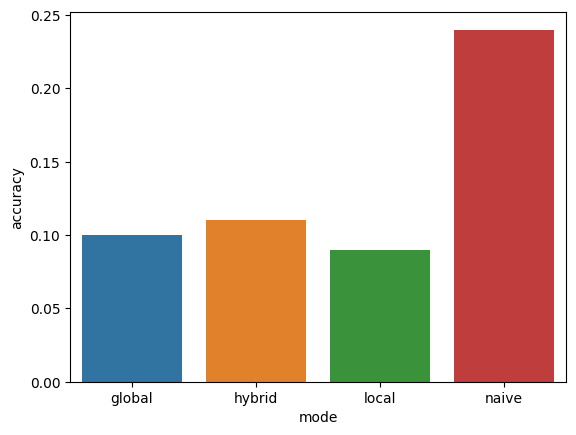

In [41]:
import seaborn as sns

sns.barplot(x='mode', y='accuracy', data=metrics_df)